* Rmix together with plume center location plot.

In [32]:
import numpy as np
import netCDF4 as nc
from salishsea_tools import (nc_tools,viz_tools,tidetools,geo_tools,stormtools)
import datetime, os
from glob import glob
import matplotlib.pyplot as plt
import StraTimeSeries as sts
import DetermineEdgePlume as DEP
import R_mixStuff as RS
from R_mixStuff import sites
import seaborn as sns
import wind
sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=2.5, rc={"lines.linewidth": 2})
%matplotlib inline

In [2]:
grid6 = nc.Dataset('/ocean/jieliu/research/meopar/river-treatment/bathy_meter_SalishSea6.nc')
X = grid6.variables['nav_lon'][:, :]
Y = grid6.variables['nav_lat'][:, :]
bathy = grid6.variables['Bathymetry'][:, :]
## tmask
mesh = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/oct8_101e061e05/mesh_mask.nc')
tmask = mesh.variables['tmask'][0,:,380:510,240:397]
np_mask = np.abs(1-tmask) 

In [3]:
## load grid_T model results
octriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014OnlyRiver/oct2014onlyriver_T.nc')
mayriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015OnlyRiver/may2015onlyriver_T.nc')
janriver_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016OnlyRiver/jan2016onlyriver_T.nc')

octall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014combineall/oct2014all_T.nc')
mayall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015combineall/may2015all_T.nc')
janall_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016combineall/jan2016all_T.nc')

octnowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nowind/oct2014nowind_T.nc')
maynowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nowind/may2015nowind_T.nc')
jannowind_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nowind/jan2016nowind_T.nc')

octnotide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014notides/oct2014notides_T.nc')
maynotide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015notides/may2015notides_T.nc')
jannotide_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016notides/jan2016notides_T.nc')

octnof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Oct2014nof/oct2014nof_T.nc')
maynof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/May2015nof/may2015nof_T.nc')
jannof_T = nc.Dataset('/data/jieliu/MEOPAR/SurfaceCurrent/Jan2016nof/jan2016nof_T.nc')

In [4]:
def get_Rmix(gridT1,gridT2,gridT3,gridT4,gridT5,tst,ted,dep_ind):
    """This function was made to get the time averaged Rmix"""
    rmix = {};
    for grid_T,st,in zip([gridT1,gridT2,gridT3,gridT4,gridT5],['onlyriver','river+tides',\
                        'river+winds','nof','all']):
        S = grid_T.variables['vosaline']
        lon = grid_T.variables['nav_lon']
        dep = grid_T.variables['deptht']

        S_ave = np.nanmean(S[tst:ted+1],axis = 0)
        rmix[st] = RS.R_mixAve(S_ave,np_mask,dep_ind)
    return rmix

In [5]:
def determine_plume_method2_onlysalinity(grid_T,tst,ted,dep_ind,ave_flag = False):
    """Similar to method1, but this time the S_ref is the spatial mean 
    of the 2.5*2.5 km in the northern of my subdomain and not plot them, only get the
    threshold salinity"""
    S = grid_T.variables['vosaline']
    lon = grid_T.variables['nav_lon']
    lat = grid_T.variables['nav_lat']
    S_aveN = np.nanmean(S[tst:ted,:,-5:,0:5],axis = 0) ## first temporal average of northern region
    S_ref = np.nanmean(S_aveN[dep_ind]) ## then spatial average at specific depth
    S_aveW = np.nanmean(S[tst:ted,dep_ind],axis = 0)
    S_thre = 1.14*S_ref-4.8
    S_aveW = np.ma.masked_values(S_aveW, 0) ## mask 0 value
    return S_thre, S_aveW

In [6]:
def threshold_whole_domain2(river_T,nowind_T,notide_T,nof_T,all_T,tst,ted,yslices,xslices,dep_ind,dep,cmap):
    """This is another criteria for determine near of far field
        (Rmix(wind)-Rmix(tide))/Rmix(all)>0.1 then far field"""
    thre_values = []; thre_js = [];thre_is = [];
    rmix = get_Rmix(river_T,nowind_T,notide_T,nof_T,all_T,tst,ted,dep_ind)
    threshold = (rmix['river+winds'] - rmix['river+tides'])/rmix['all']
    lon = all_T.variables['nav_lon']
    lat = all_T.variables['nav_lat']
    levels = np.arange(-0.1,0.4,0.1)
    origin = 'lower';
    CS = plt.contourf(lon[:,:xslices],lat[:,:xslices],threshold[:,:xslices],levels,cmap = cmap,origin=origin,extend='both')
    CS2 = plt.contour(CS,levels=CS.levels,colors = 'k', origin=origin,hold='on',linewidths=(2,))

    ## plot plume edge on top of the different plume regions
    S_thre,W = determine_plume_method2_onlysalinity(all_T,tst,ted,dep)
    CS3 = plt.contour(lon[:],lat[:],W, levels = [S_thre], colors='cyan',linewidths=(3.5))
    plt.clabel(CS3,fmt='%2.1f', colors='k',fontsize = 14)
    return CS,CS2

In [30]:
river_gridTs = [janriver_T,janriver_T,janriver_T,octriver_T,octriver_T,octriver_T,mayriver_T,mayriver_T,mayriver_T];
nowind_gridTs = [jannowind_T,jannowind_T,jannowind_T,octnowind_T,octnowind_T,octnowind_T,maynowind_T,maynowind_T,maynowind_T];
notide_gridTs  = [jannotide_T,jannotide_T,jannotide_T,octnotide_T,octnotide_T,octnotide_T,maynotide_T,maynotide_T,maynotide_T];
nof_gridTs = [jannof_T,jannof_T,jannof_T,octnof_T,octnof_T,octnof_T,maynof_T,maynof_T,maynof_T];
all_gridTs = [janall_T,janall_T,janall_T,octall_T,octall_T,octall_T,mayall_T,mayall_T,mayall_T];
tsts = [168,384,624,48,408,480,192,432,24];
teds = [239,455,671,143,480,551,263,503,71];
strings = ['a','d','g','b','e','h','c','f','i']
jss_nowind = [69,85,81,66,70,70,73,83,70]
iss_nowind = [51,52,48,49,48,47,46,44,55]

jss = [70,86,85,68,92,88,73,68,48]
iss = [51,63,57,45,56,59,49,43,43]

yslices = tmask.shape[1]
xslices = tmask.shape[2]-77

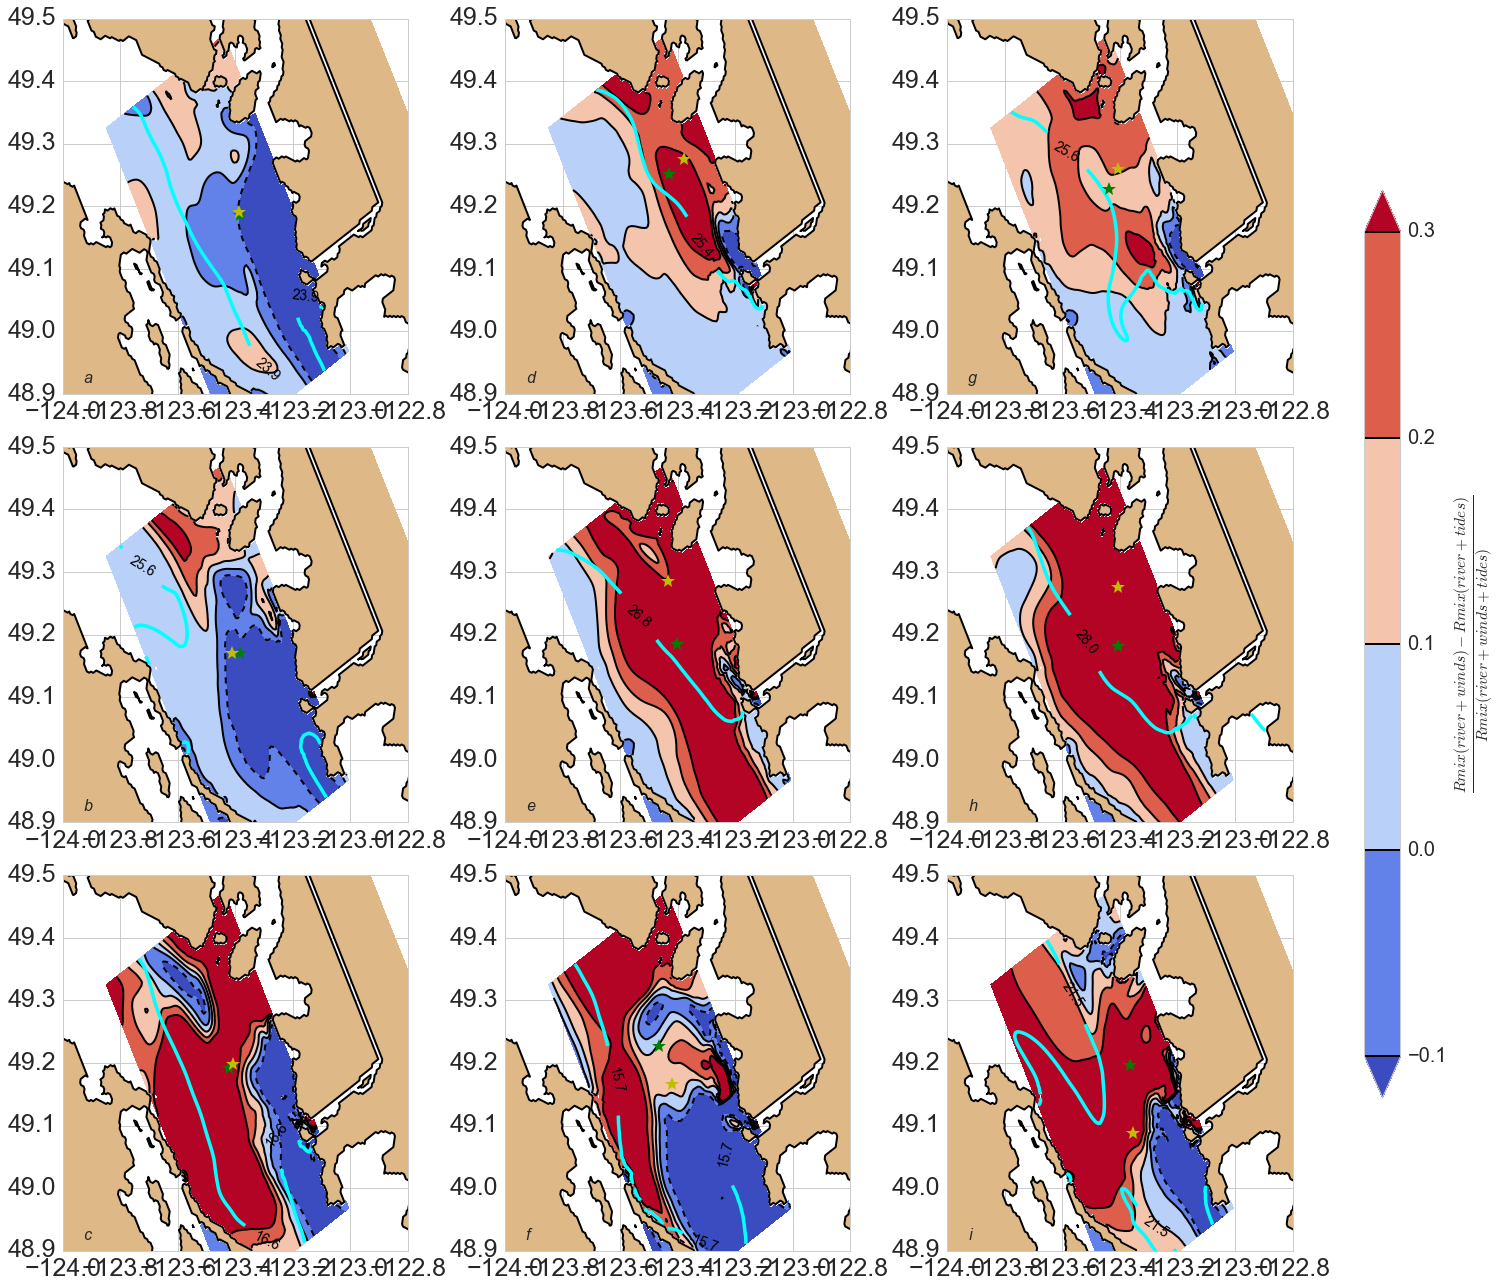

In [34]:
fig = plt.figure(figsize=(20,18))
for i, string in zip(np.arange(1,10),strings):
    ax = plt.subplot(3,3,i)
    CS,CS2 = threshold_whole_domain2(river_gridTs[i-1],nowind_gridTs[i-1],notide_gridTs[i-1],\
                                 nof_gridTs[i-1],all_gridTs[i-1],tsts[i-1],teds[i-1],yslices,xslices,10,0,cmap = 'coolwarm')   
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    ax.plot(X[380+jss_nowind[i-1],240+iss_nowind[i-1]],Y[380+jss_nowind[i-1],240+iss_nowind[i-1]],'g*',markersize = 14,\
           label = 'nowind')
    ax.plot(X[380+jss[i-1],240+iss[i-1]],Y[380+jss[i-1],240+iss[i-1]],'y*',markersize = 14,\
           label = 'all')
    ax.text(0.06,0.03,string,transform = ax.transAxes,fontsize = 16,style='oblique')
    ax.set_xlim([-124.,-122.8])
    ax.set_ylim([48.9,49.5])
plt.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
cbar = fig.colorbar(CS, cax=cbar_ax)
cbar.add_lines(CS2)
cbar.ax.tick_params(labelsize=20)
cbar.set_label(r'$\frac{Rmix(river+winds) - Rmix(river+tides)}{Rmix(river+winds+tides)}$',fontsize = 22)

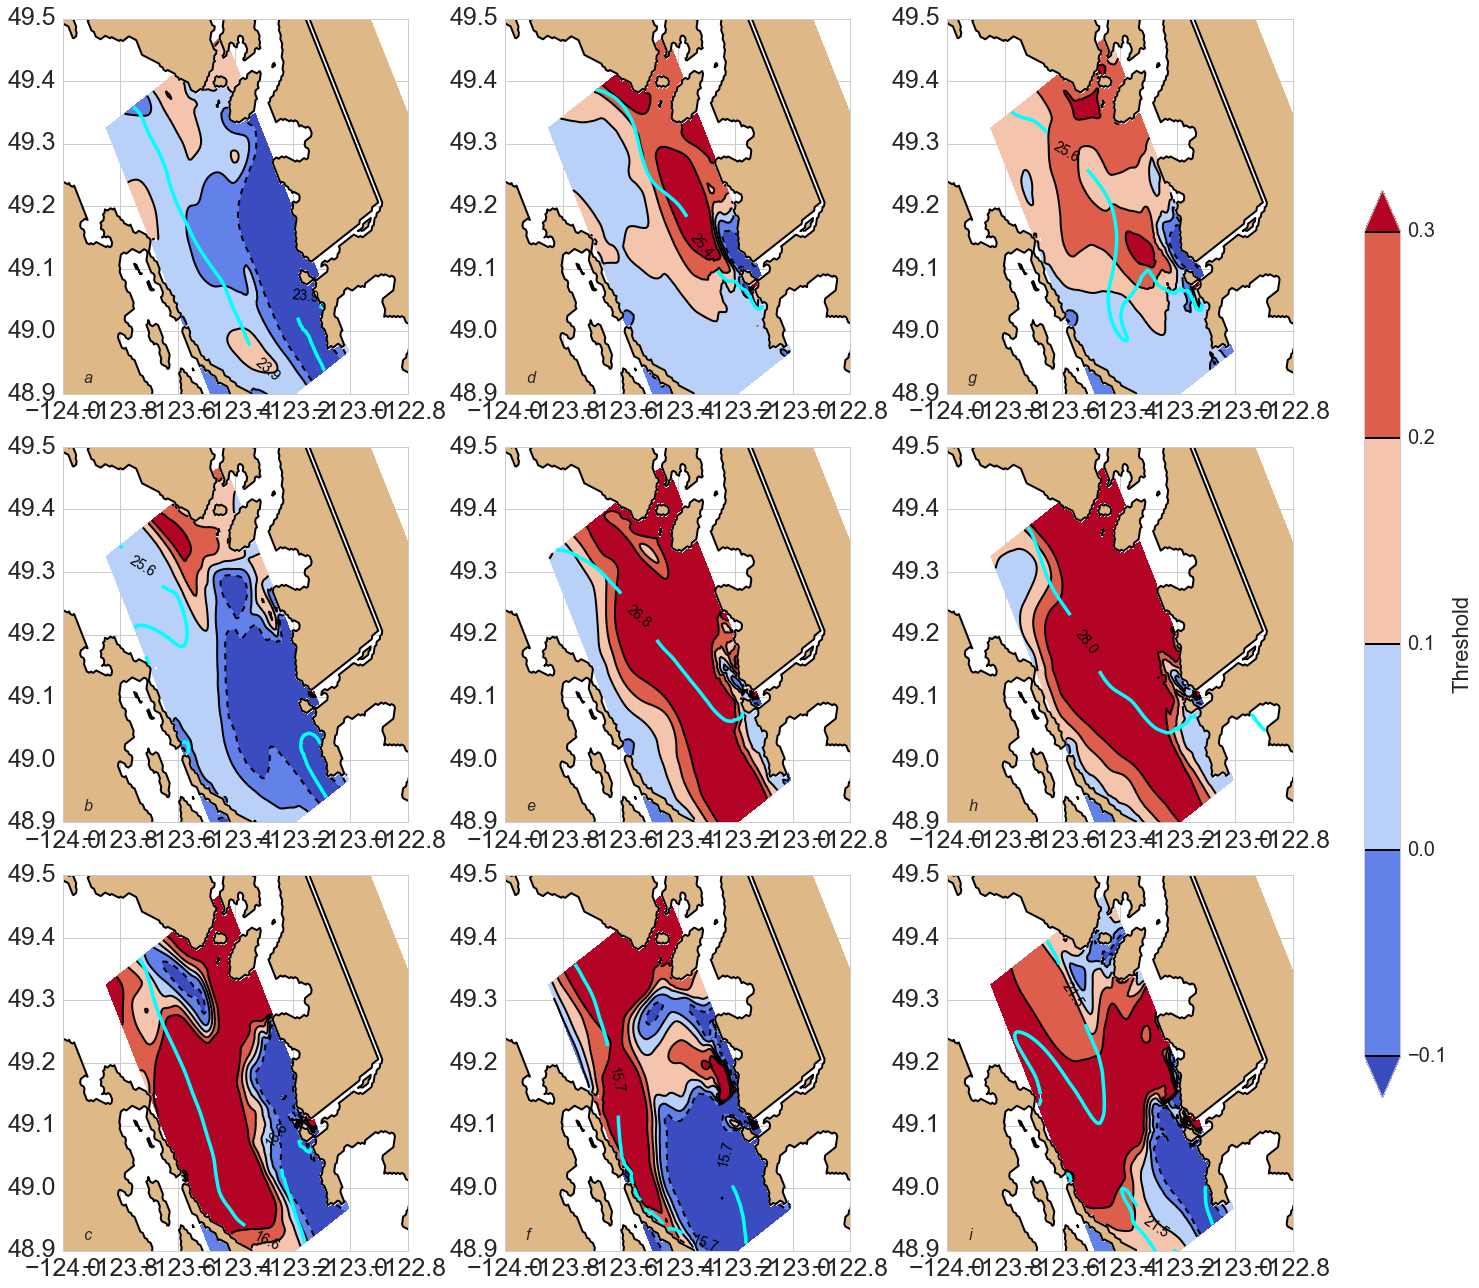

In [33]:
fig = plt.figure(figsize=(20,18))
for i, string in zip(np.arange(1,10),strings):
    ax = plt.subplot(3,3,i)
    CS,CS2 = threshold_whole_domain2(river_gridTs[i-1],nowind_gridTs[i-1],notide_gridTs[i-1],\
                                 nof_gridTs[i-1],all_gridTs[i-1],tsts[i-1],teds[i-1],yslices,xslices,10,0,cmap = 'coolwarm')   
    viz_tools.plot_land_mask(ax,grid6,coords='map',color='burlywood')
    viz_tools.plot_coastline(ax, grid6, coords = 'map')
    #ax.plot(X[380+jss_nowind[i-1],240+iss_nowind[i-1]],Y[380+jss_nowind[i-1],240+iss_nowind[i-1]],'g*',markersize = 14,\
           #label = 'nowind')
    #ax.plot(X[380+jss[i-1],240+iss[i-1]],Y[380+jss[i-1],240+iss[i-1]],'y*',markersize = 14,\
           #label = 'all')
    ax.text(0.06,0.03,string,transform = ax.transAxes,fontsize = 16,style='oblique')
    ax.set_xlim([-124.,-122.8])
    ax.set_ylim([48.9,49.5])
plt.tight_layout()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.95, 0.15, 0.025, 0.7])
cbar = fig.colorbar(CS, cax=cbar_ax)
cbar.add_lines(CS2)
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Threshold',fontsize = 22)